In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras import regularizers   

In [162]:
df = pd.read_csv('/kaggle/input/acl-task-3-dataset/AirlineScrappedReview_withSentiment.csv')

# Quick look
df.head()

,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,...,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address,Review_text,Sentiment_score,Sentiment_label,satisfaction
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,...,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",The airline lost my luggage. The airline lost ...,-0.8315,Negative,0
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,...,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",fully refunded by our travel insurance. We boo...,0.7184,Positive,0
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,...,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",no boarding drinks provided. First time flying...,-0.7964,Negative,0
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,...,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",WiFi didn't work . You can buy sandwiches and ...,-0.5849,Negative,0
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,...,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",stick with economy. This is a two-for-one revi...,0.9657,Positive,1


In [167]:
df['Verified'] = df['Verified'].apply(lambda x: 1 if x == 'Trip Verified' else 0)

In [168]:
X = df[['Traveller_Type', 'Class', 'Route', 'Sentiment_score', 'Verified']]
y = df['satisfaction']

categorical_cols = ['Traveller_Type', 'Class', 'Route']
numeric_cols = ['Sentiment_score', 'Verified']

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [170]:
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.metrics import Precision, Recall

model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 8)              │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,457 (48.66 KB)

 Trainable params: 12,457 (48.66 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

history = model.fit(
    X_train, y_train, 
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4565 - loss: 0.8734 - precision: 0.4360 - recall: 0.4949 - val_accuracy: 0.4860 - val_loss: 0.7615 - val_precision: 0.4791 - val_recall: 0.4452 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5594 - loss: 0.7379 - precision: 0.5511 - recall: 0.3425 - val_accuracy: 0.4965 - val_loss: 0.7482 - val_precision: 0.4627 - val_recall: 0.1095 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6002 - loss: 0.7038 - precision: 0.6729 - recall: 0.3504 - val_accuracy: 0.5105 - val_loss: 0.7431 - val_precision: 0.5238 - val_recall: 0.1166 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7049 - loss: 0.6585 - precision: 0.7882 - recall: 0.5184 - val_accuracy: 0.5647 - val_loss: 0.7372 - val_precision: 0.6635 - val_recall: 0.2438 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7292 - 

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_probs = model.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Accuracy:", round(accuracy, 3))
print("Test Precision:", round(precision, 3))
print("Test Recall:", round(recall, 3))
print("Test F1-Score:", round(f1, 3))

print("\nDetailed classification report:")
print(classification_report(y_test, y_pred))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.758
Test Precision: 0.741
Test Recall: 0.765
Test F1-Score: 0.753

Detailed classification report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       371
           1       0.74      0.76      0.75       344

    accuracy                           0.76       715
   macro avg       0.76      0.76      0.76       715
weighted avg       0.76      0.76      0.76       715



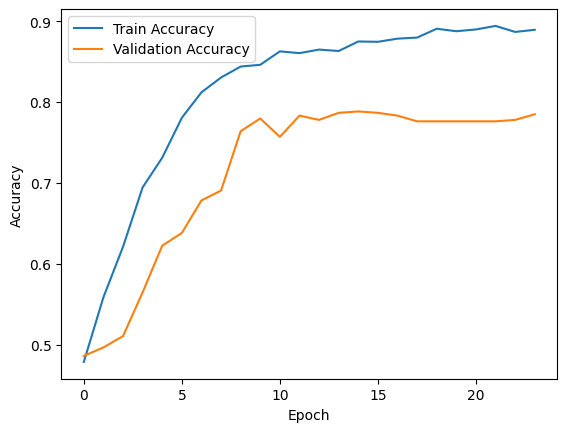

In [173]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
